<a href="https://colab.research.google.com/github/marudever/MLPY_LinearRegression1_Titanic/blob/main/MLPY_Linear_Regression_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook talk about Linear Regression to make prediction
**the survival rate** of passangers from the **Titanic Dataset**

# Setup and Imports
We need to install sklearn and import the following modules

In [21]:
!pip install -q sklearn

In [22]:
%tensorflow_version 2.x 

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [37]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

# Data
Load the dataset using pandas.
Because we want to predict if the person survived or not, we have decided to pop the "survived" column from the dataset nad store it in a new variable.

In [24]:
# Load Dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # Training Data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')   # Testing Data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

Let's see the data to check to confirm we loaded the datafrane using .head()

In [25]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


Use the .describe() method for more statistical analysing of the data.

In [26]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


Shape(x,y) information: x = entries, y = features.

In [27]:
dftrain.shape

(627, 9)

Survival information. 0 = not survived, 1 = survived.

In [28]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

# Graphs / Visuals

Histogram about the passanger ages in Titanic:

<AxesSubplot:>

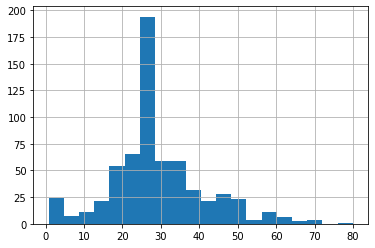

In [29]:
dftrain.age.hist(bins=20)

Horizonal graph about sex distribution:

<AxesSubplot:>

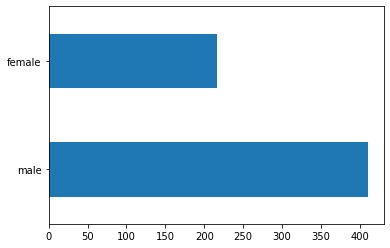

In [30]:
dftrain.sex.value_counts().plot(kind='barh')

The class distribution of passangers:

<AxesSubplot:>

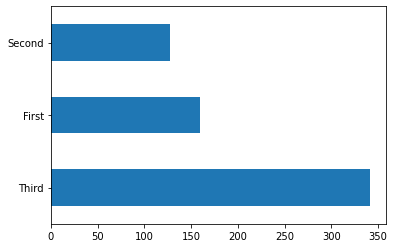

In [31]:
dftrain['class'].value_counts().plot(kind='barh')

Survival rate based on sex:

Text(0.5, 0, '% Survive')

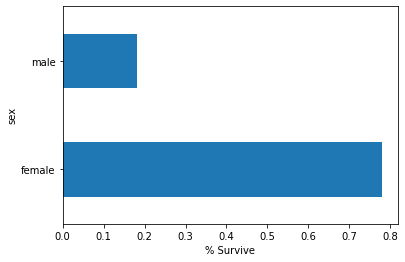

In [32]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% Survive')

# Training and Testing
### Feature Columns
Fyi, we have two different kinds of information in the dataset: Categorical and Numeric.
Categorical data is anything that is not numeric. For example: sex column ("male" and "female"). While numeric data is anything that use number like age.

Before create/train a model, we must convert the categorical data into numeric data. Let's do this by encode each category with an integer. Ex: male = 1, female = 2.

In [33]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

### The Training Process
First, THERE IS NOW WAY if we fed the model with everything inside dataset. Just imagine if you have 10TB of data, then we fed the model with it. It need a lot of times to complete, also huge resource. Except you have super computer.

So we will make it in small batches of 32. This meand we will not feed the entire dataset to our model at once, but just small batches of entries. Also we will feed multiple times using the number of epochs.


### Epoch
An epoch refers to a complete pass through the entire training dataset during the training phase of a model. The number of epochs we define is the amount of times our model will see the entire dataset. We use multiple epochs in hope that after seeing the same data multiple times the model will better determine how to estimate it.

Also, the same training data is typically fed to the model, but the order of the examples can be shuffled or randomized to ensure that the model is not simply memorizing the training set.

### Input Function
In programming, an input function is a mechanism that allows the user to provide data or information to the program.

In the context of machine learning, an input function is a way to feed data into a model during the training process. The input function takes care of reading in the data, preprocessing it (normalizing the values, shuffling the data, batching it), and passing it to the model in a format that the model can understand.

In [34]:
def make_input_function(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_function = make_input_function(dftrain, y_train)
eval_input_function = make_input_function(dfeval, y_eval, num_epochs=1, shuffle=False)

# Creating the Model
We are using a linear estimator to utilize the linear regression algotihm

In [35]:
linear_estimator = tf.estimator.LinearClassifier(feature_columns=feature_columns)

### Training the Model

In [36]:
linear_estimator.train(train_input_function)
result = linear_estimator.evaluate(eval_input_function)

clear_output()
print(result['accuracy'])

ValueError: ignored